## 1. EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
df = pd.read_excel("Ground_truth.xlsx", sheet_name="Apps")

# 1. Basic Info
print("🔹 Basic Info:")
print(df.info())
print("\n🔹 Missing Values:")
print(df.isnull().sum())

🔹 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   App id                   2062 non-null   object
 1   Review id                2062 non-null   object
 2   Sentence id              2062 non-null   int64 
 3   Sentence content         2062 non-null   object
 4   Feature (Positive)       291 non-null    object
 5   Feature (Neutral)        638 non-null    object
 6   Feature (Negative)       110 non-null    object
 7   Feature (All Annotated)  971 non-null    object
dtypes: int64(1), object(7)
memory usage: 129.0+ KB
None

🔹 Missing Values:
App id                        0
Review id                     0
Sentence id                   0
Sentence content              0
Feature (Positive)         1771
Feature (Neutral)          1424
Feature (Negative)         1952
Feature (All Annotated)    1091
dtype: int64


In [3]:
# 2. Feature counts
print("\n🔹 Feature Counts:")
feature_cols = ['Feature (Positive)', 'Feature (Neutral)', 'Feature (Negative)', 'Feature (All Annotated)']
for col in feature_cols:
    print(f"{col}: {df[col].notnull().sum()}")


🔹 Feature Counts:
Feature (Positive): 291
Feature (Neutral): 638
Feature (Negative): 110
Feature (All Annotated): 971


Off the total 2062 review entries, only 971 are annotated as either positive, negative or neutral.

In [4]:
# 3. Most common features
print("\n🔹 Top Features:")
for col in feature_cols:
    top_features = df[col].dropna().value_counts().head(10)
    print(f"\nTop {col}:")
    print(top_features)


🔹 Top Features:

Top Feature (Positive):
Feature (Positive)
pictures          4
navigate          4
photo editing     3
shopping          3
install           3
music             3
shop              3
Skitch            2
streaming         2
user interface    2
Name: count, dtype: int64

Top Feature (Neutral):
Feature (Neutral)
update       11
open          8
install       7
video         6
movies        5
watch         5
reinstall     4
updates       4
shop          4
updated       4
Name: count, dtype: int64

Top Feature (Negative):
Feature (Negative)
update                                 8
interface                              2
updates                                2
load                                   2
syncing                                2
privacy sttings                        1
uploading                              1
protect the sharing;protect posting    1
loads                                  1
posts loading                          1
Name: count, dtype: int64

Top 

This is informative --> `update`, `install`, `shop`, `open`, `video`, `updates`, `pictures`, `reinstall`, `top bar` and `navigate` are the most common annotated features.

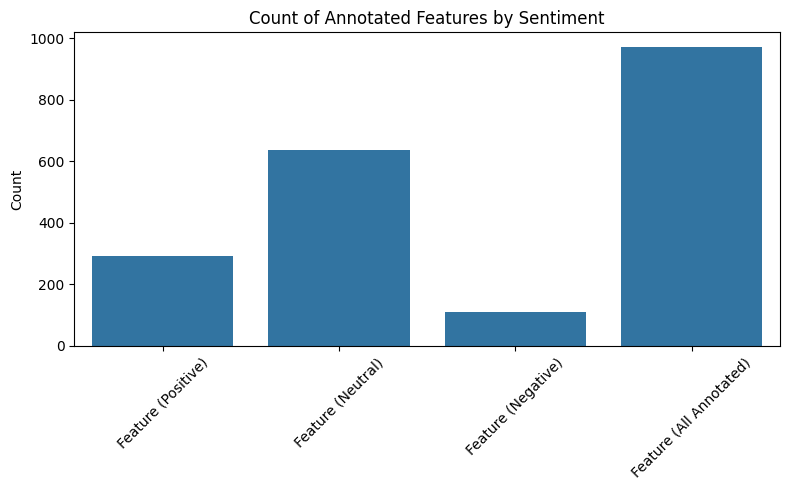

In [5]:
# 4. Distribution Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_cols, y=[df[col].notnull().sum() for col in feature_cols])
plt.title("Count of Annotated Features by Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Of all the features, `600+` have a neutral annotation, followed by around `300` have positive and only around `150` have negative annotation. 

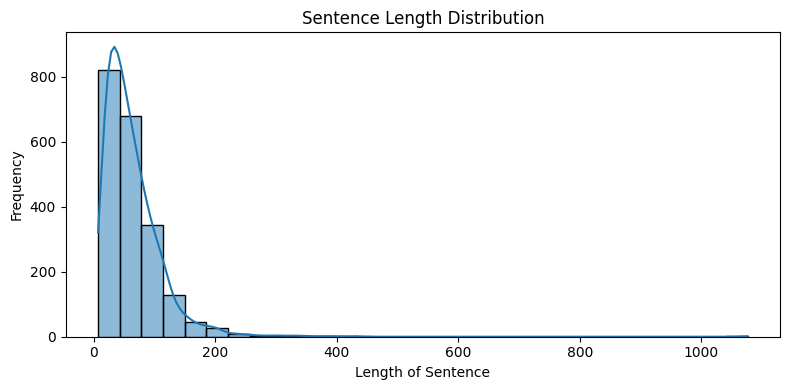

In [6]:
# 5. Sentence length distribution
df['sentence_length'] = df['Sentence content'].astype(str).apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(df['sentence_length'], bins=30, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Length of Sentence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

This is right-skewed indicating shorter user reviews (number of words per sentence) are more common

## 2. Mistral AI

In [7]:
import ollama
import pandas as pd
from tqdm import tqdm

def mistral_sentiment_row(review):
    #review = row['Sentence content']
    prompt = (
        "Classify the sentiment of the following app review sentence as Positive, Negative, Neutral, or Unsure. "
        "Be careful to detect sarcasm, irony, and backhanded compliments. "
        "If sarcasm is detected, classify the sentiment based on intent, not literal meaning.\n\n"
        f"Review: \"{review}\""
    )
    try:
        response = ollama.chat(
            model='mistral',
            messages=[
                {"role": "system", "content": "You are a sarcasm-aware sentiment analysis model."},
                {"role": "user", "content": prompt}
            ]
        )
        prediction = response['message']['content'].strip()
        return prediction
    except Exception as e:
        return f"Error: {e}"

In [8]:
# Define the ground truth sentiment column (you can pick based on priority)
def get_ground_truth(row):
    if pd.notnull(row['Feature (Positive)']):
        return 'Positive'
    elif pd.notnull(row['Feature (Negative)']):
        return 'Negative'
    elif pd.notnull(row['Feature (Neutral)']):
        return 'Neutral'
    else:
        return None

# Add ground truth to the DataFrame
df['GroundTruth'] = df.apply(get_ground_truth, axis=1)

# Filter only annotated rows
annotated_df = df[df['GroundTruth'].notnull()].copy()

In [9]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# Parallel runner
def run_parallel_inference(reviews, max_workers=5):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_review = {executor.submit(mistral_sentiment_row, review): review for review in reviews}
        for i, future in enumerate(as_completed(future_to_review), 1):
            review = future_to_review[future]
            try:
                sentiment = future.result()
                results.append((review, sentiment))
            except Exception as exc:
                results.append((review, f"Error: {exc}"))
            print(f"[{i}/{len(reviews)}] Processed")
    return results

# Run the parallel job
start = time.time()
reviews = annotated_df['Sentence content'].tolist()
parallel_results = run_parallel_inference(reviews, max_workers=5)
end = time.time()

print(f"\n🎉 Completed in {end - start:.2f} seconds")

[1/971] Processed
[2/971] Processed
[3/971] Processed
[4/971] Processed
[5/971] Processed
[6/971] Processed
[7/971] Processed
[8/971] Processed
[9/971] Processed
[10/971] Processed
[11/971] Processed
[12/971] Processed
[13/971] Processed
[14/971] Processed
[15/971] Processed
[16/971] Processed
[17/971] Processed
[18/971] Processed
[19/971] Processed
[20/971] Processed
[21/971] Processed
[22/971] Processed
[23/971] Processed
[24/971] Processed
[25/971] Processed
[26/971] Processed
[27/971] Processed
[28/971] Processed
[29/971] Processed
[30/971] Processed
[31/971] Processed
[32/971] Processed
[33/971] Processed
[34/971] Processed
[35/971] Processed
[36/971] Processed
[37/971] Processed
[38/971] Processed
[39/971] Processed
[40/971] Processed
[41/971] Processed
[42/971] Processed
[43/971] Processed
[44/971] Processed
[45/971] Processed
[46/971] Processed
[47/971] Processed
[48/971] Processed
[49/971] Processed
[50/971] Processed
[51/971] Processed
[52/971] Processed
[53/971] Processed
[5

In [16]:
parallel_results[:5]

[('Too many ads and secondly erratic interface.',
  'Negative (based on intended sentiment; sarcastic tone indicates a negative opinion despite using seemingly positive words)'),
 ('Cant get to install',
  'The sentiment in this review can be classified as Negative, but it\'s important to note that there seems to be a hint of sarcasm or irony. The user is expressing frustration about being unable to install the app, which could indicate a problem with the installation process. However, the use of "Cant" in this context suggests a level of exaggeration and may imply that the issue is not as dire as it sounds. In essence, the user appears to be sarcastically expressing their difficulty while expecting the app or its support team to resolve the issue promptly.'),
 ('I have already uninstalled',
  'Based on the sarcasm in this review, the sentiment can be classified as Negative. The user is implying that they are unhappy with the app and have chosen to remove it from their device.'),
 ('I 

In [19]:
# Add results back to the DataFrame
results_df = pd.DataFrame(parallel_results, columns=['Sentence content', 'MistralPrediction'])
#annotated_df = annotated_df.merge(results_df[['MistralPrediction']], how='left')

# 5. Save the results file
results_df.to_excel("results_sentiment_output.xlsx", index=False)
print("Sentiment analysis complete. Results saved to 'results_sentiment_output.xlsx'.")

Sentiment analysis complete. Results saved to 'results_sentiment_output.xlsx'.


In [ ]:
import ollama
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# -------------------------
# 1. Mistral sentiment function
# -------------------------
def mistral_sentiment(review):
    prompt = (
        "Classify the sentiment of the following app review sentence as Positive, Negative, Neutral, or Unsure. "
        "Be careful to detect sarcasm, irony, and backhanded compliments. "
        "If sarcasm is detected, classify the sentiment based on intent, not literal meaning.\n\n"
        f"Review: \"{review}\""
    )
    try:
        response = ollama.chat(
            model='mistral',
            messages=[
                {"role": "system", "content": "You are a sarcasm-aware sentiment analysis model."},
                {"role": "user", "content": prompt}
            ]
        )
        return response['message']['content'].strip()
    except Exception as e:
        return f"Error: {e}"

# -------------------------
# 2. Extract ground truth & filter rows
# -------------------------
# df = pd.read_csv("your_file.csv")  # or however you load it

def get_ground_truth(row):
    if pd.notnull(row['Feature (Positive)']):
        return 'Positive'
    elif pd.notnull(row['Feature (Negative)']):
        return 'Negative'
    elif pd.notnull(row['Feature (Neutral)']):
        return 'Neutral'
    else:
        return None

df['GroundTruth'] = df.apply(get_ground_truth, axis=1)
annotated_df = df[df['GroundTruth'].notnull()].copy()

# Assign unique row_id to make merging efficient
annotated_df['row_id'] = annotated_df.index

# -------------------------
# 3. Run sentiment inference in parallel
# -------------------------
def run_parallel_inference(rows, max_workers=5):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_row = {
            executor.submit(mistral_sentiment, row['Sentence content']): row
            for row in rows
        }
        for i, future in enumerate(as_completed(future_to_row), 1):
            row = future_to_row[future]
            try:
                sentiment = future.result()
                results.append((row['row_id'], row['Sentence content'], sentiment))
            except Exception as exc:
                results.append((row['row_id'], row['Sentence content'], f"Error: {exc}"))
            print(f"[{i}/{len(rows)}] Processed")
    return results

start = time.time()
rows = annotated_df[['row_id', 'Sentence content']].to_dict('records')
parallel_results = run_parallel_inference(rows, max_workers=5)
end = time.time()

print(f"\n🎉 Completed in {end - start:.2f} seconds")

# -------------------------
# 4. Add results back to the DataFrame
# -------------------------
results_df = pd.DataFrame(parallel_results, columns=['row_id', 'Sentence content', 'MistralPrediction'])
annotated_df = annotated_df.merge(results_df[['row_id', 'MistralPrediction']], on='row_id', how='left')


# -------------------------
# 5. Save the results and final annotated file
# -------------------------
results_df.to_excel("results_sentiment_output.xlsx", index=False)
annotated_df.to_excel("annotated_sentiment_output.xlsx", index=False)
print("Sentiment analysis complete. Results saved to 'results_sentiment_output.xlsx' and 'annotated_sentiment_output.xlsx' respectively.")